In [ ]:
pip install timm einops

In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


In [1]:
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 
import os 
from transformers import AutoProcessor, AutoModelForCausalLM
from transformers.dynamic_module_utils import get_imports
from unittest.mock import patch

c:\Users\sselva\Downloads\florence2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 
import os 
from transformers import AutoProcessor, AutoModelForCausalLM
from transformers.dynamic_module_utils import get_imports
from unittest.mock import patch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
 
def fixed_get_imports(filename: str | os.PathLike) -> list[str]:
    if not str(filename).endswith("modeling_florence2.py"):
        return get_imports(filename)
    imports = get_imports(filename)
    # imports.remove("flash_attn")
    return imports
 
with patch("transformers.dynamic_module_utils.get_imports", fixed_get_imports): #workaround for unnecessary flash_attn requirement
    model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
 
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
c:\Users\sselva\Downloads\florence2\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokeniz

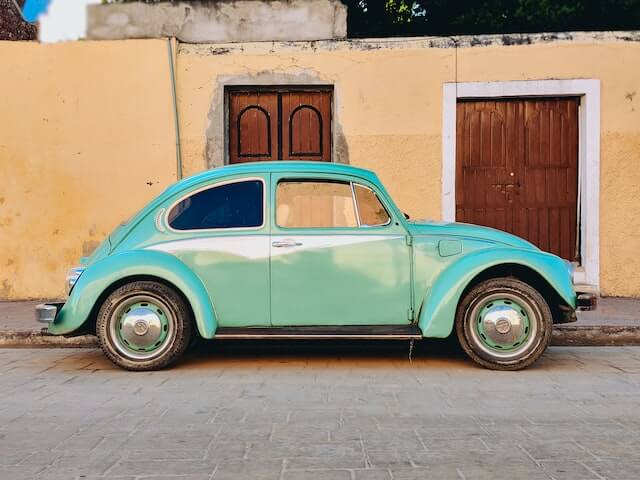

In [3]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)
image

In [4]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cpu', torch.float32)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cpu(),
      pixel_values=inputs["pixel_values"].cpu(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [5]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[34.880001068115234, 158.63999938964844, 582.0800170898438, 374.1600036621094]], 'bboxes_labels': ['a green car'], 'polygons': [], 'polygons_labels': []}}


In [36]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}

In [7]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [272.32000732421875, 241.67999267578125, 303.67999267578125, 247.4399871826172], [454.0799865722656, 276.7200012207031, 553.9199829101562, 370.79998779296875], [96.31999969482422, 280.55999755859375, 198.0800018310547, 371.2799987792969]], 'labels': ['car', 'door handle', 'wheel', 'wheel']}}


In [6]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show() 

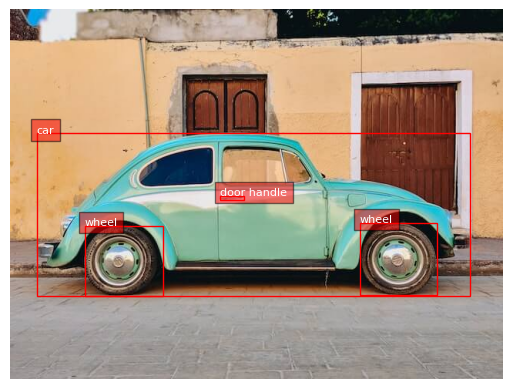

: 

In [9]:
plot_bbox(image, results['<OD>'])


{'bboxes': [[35.52000045776367, 158.63999938964844, 580.7999877929688, 372.7200012207031]], 'labels': ['green car']}


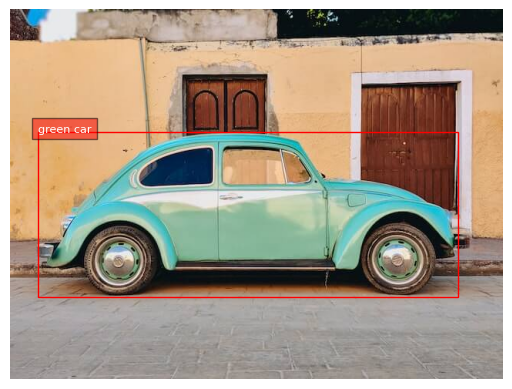

In [16]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
text_input="green car"
results = run_example(task_prompt, text_input)
print(results[task_prompt])
plot_bbox(image, results[task_prompt])

In [ ]:
if task_selected == "Caption to Phrase Grounding":
    text_input = st.text_input("Enter additional text input (optional)", "")
    
    task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
    st.write("Running Caption to Phrase Grounding...")

    # Run the model to get results
    results = run_example(image, task_prompt, text_input)
    
    # Construct the key by combining task_prompt and text_input
    result_key = f"{task_prompt}{text_input}"
    
    if result_key in results:
        # Extract the bounding box coordinates from the result string
        result_string = results[result_key]
        st.write("Result String:", result_string)
        
        # Example: result_string = "green car<loc_55><loc_330><loc_907><loc_776>"
        # Extract the coordinates by finding <loc_> patterns
        import re
        loc_matches = re.findall(r"<loc_(\d+)>", result_string)
        
        # Check if we have exactly four coordinates for the bounding box
        if len(loc_matches) == 4:
            x1, y1, x2, y2 = map(int, loc_matches)
            bounding_box = [(x1, y1, x2, y2)]
            labels = [text_input]  # The label is the input phrase
            
            # Prepare data in the format required by plot_bbox
            result_data = {'bboxes': bounding_box, 'labels': labels}
            
            # Plot the bounding box
            plot_bbox(image, result_data)
        else:
            st.write("Error: Couldn't extract valid bounding box coordinates from the result.")
    else:
        st.write(f"Key error: Couldn't find {result_key} in the results.")

In [17]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[178.87998962402344, 182.1599884033203, 180.8000030517578, 182.1599884033203, 185.9199981689453, 178.8000030517578, 187.83999633789062, 178.8000030517578, 191.0399932861328, 176.87998962402344, 192.95999145507812, 176.87998962402344, 196.1599884033203, 174.95999145507812, 198.72000122070312, 174.0, 201.9199981689453, 173.0399932861328, 205.1199951171875, 172.0800018310547, 207.67999267578125, 170.63999938964844, 212.1599884033203, 169.67999267578125, 216.0, 168.72000122070312, 219.83999633789062, 167.75999450683594, 223.67999267578125, 166.8000030517578, 228.1599884033203, 165.83999633789062, 233.9199981689453, 164.87998962402344, 240.95999145507812, 163.9199981689453, 249.9199981689453, 162.95999145507812, 262.0799865722656, 162.0, 313.2799987792969, 162.0, 329.2799987792969, 162.95999145507812, 338.239990234375, 163.9199981689453, 345.2799987792969, 164.87998962402344, 350.3999938964844, 165.83999633789062, 354.239990234375, 166.

In [18]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

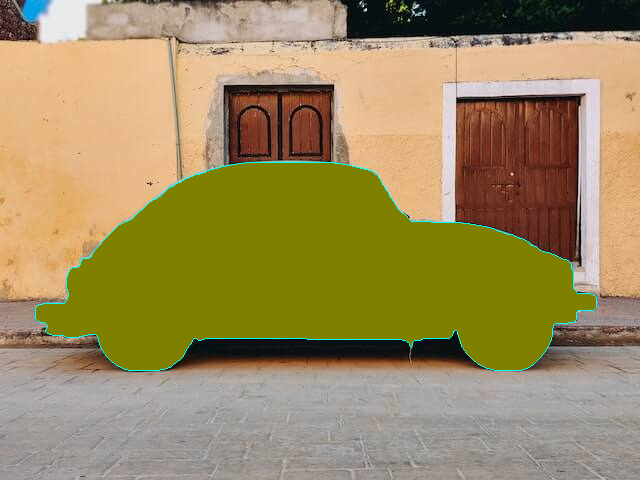

In [19]:
import copy
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)  
